In [8]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:


def get_local_alt(f):
    to_local = lambda f : f.replace('/eos/user/e/ekoenig/','/store/user/ekoenig/')
    alt_pattern = to_local(f)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    if any(alt_glob):
        return alt_glob
    
    remote_glob = fc.fs.cernbox.glob(f)
    if any(remote_glob):
        alt_glob = [ to_local(f) for f in remote_glob ]
        remote_glob = [ fc.fs.cernbox.fullpath(f) for f in remote_glob ]
        fc.fs.eos.batch_copy_to(remote_glob, alt_glob)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    return alt_glob

In [24]:

treekwargs = dict(
    use_gen=False,
    treename='Events',
    normalization=None,
)

f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/trg/{pairing}_2018_0L/data/jetht_tree.root'
f_data = f_pattern.format(pairing='btagfix/feynnet')

data = ObjIter([Tree( get_local_alt(f_data), **dict(treekwargs, normalization=None, color='black'))])

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


In [25]:
data = data.apply(lambda t : t.subset(nentries=200000, randomize=False))

In [26]:
model_path = '/eos/uscms/store/user/ekoenig/lightning/models/feynnet_lightning/nanoHH4b/training-25Sep2023/lightning_logs/version_11054562'
load_feynnet = fourb.nanohh4b.f_evaluate_feynnet(model_path)

import multiprocess as mp
with mp.Pool(1) as pool:
            (data).parallel_apply(load_feynnet, pool=pool, report=True)

f_evaluate_feynnet: 100%|██████████| 1/1 [00:09<00:00,  9.63s/it]


In [27]:
def n_loose_btag(t):
    nL = t.ak4_h1b1_btag_L + t.ak4_h1b2_btag_L + t.ak4_h2b1_btag_L + t.ak4_h2b2_btag_L
    return ak.values_astype(nL, np.int32)

def n_medium_btag(t):
    nM = t.ak4_h1b1_btag_M + t.ak4_h1b2_btag_M + t.ak4_h2b1_btag_M + t.ak4_h2b2_btag_M
    return ak.values_astype(nM, np.int32)

def n_tight_btag(t):
    nT = t.ak4_h1b1_btag_T + t.ak4_h1b2_btag_T + t.ak4_h2b1_btag_T + t.ak4_h2b2_btag_T
    return ak.values_astype(nT, np.int32)

def h_dm(t):
    return np.sqrt( (t.dHH_H1_regmass - 125)**2 + (t.dHH_H2_regmass - 120)**2 )

def vr_h_dm(t):
    return np.sqrt( (t.dHH_H1_regmass - 179)**2 + (t.dHH_H2_regmass - 172)**2 )

bdt_features = [
    'ak4_h1b1_regpt', 'ak4_h1b2_regpt', 'ak4_h2b1_regpt', 'ak4_h2b2_regpt',
    'dHH_H1_regmass', 'dHH_H2_regmass', 'dHH_H1_pt', 'dHH_H2_pt', 
    'dHH_HH_mass', 'dHH_HH_pt','dHH_SumRegPtb', 'dHH_SumRegResb',
    'dHH_H1b1_H1b2_deltaR', 'dHH_H2b1_H2b2_deltaR', 'dHH_H1_H2_deltaEta','dHH_mindRbb', 
    'dHH_maxdEtabb','dHH_absCosTheta_H1_inHHcm', 'dHH_absCosTheta_H1b1_inH1cm', 'dHH_NbtagT',
]

bdt = ABCD(
    features=bdt_features,
    a=lambda t : (h_dm(t) <  25) & (n_medium_btag == 4),
    b=lambda t : (h_dm(t) <  25) & (n_medium_btag == 3),
    c=lambda t : (h_dm(t) >= 25) & (h_dm(t) < 50) & (n_medium_btag == 4),
    d=lambda t : (h_dm(t) >= 25) & (h_dm(t) < 50) & (n_medium_btag == 3),
)

blind_data = EventFilter('blinded', filter=lambda t : ~bdt.a(t))
data = data.apply(blind_data)

100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


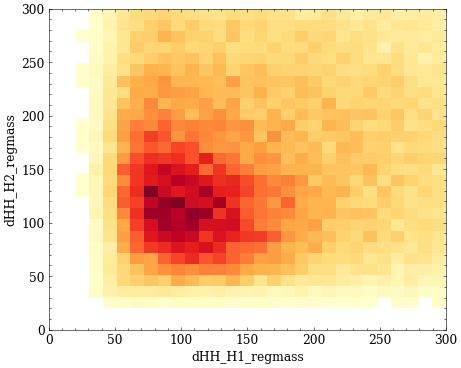

In [28]:
study.quick2d(
    data,
    masks=lambda t : n_medium_btag(t) == 3,
    varlist=['dHH_H1_regmass', 'dHH_H2_regmass'],
    binlist=[(0, 300, 30)]*2
)

In [7]:
h1b1_p4 = ak.zip(dict(
    pt=t2.ak4_h1b1_pt,
    eta=t2.ak4_h1b1_eta,
    phi=t2.ak4_h1b1_phi,
    mass=t2.ak4_h1b1_mass,
), with_name='Momentum4D')